In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [7]:
cfg.model.decoder.kwargs.update({'n_bands': 1, 
                             'slen': 300, 
                             'tile_slen': 10, 
                             'ptile_slen': 30, 
                             'border_padding': 5, 
                             'mean_sources': 0.0,
                             'background_values': [680], 
                             'psf_params_file': './zband_psf_simple.npy'})

cfg.model.encoder.kwargs.update({'ptile_slen': 20})

cfg.dataset.kwargs.update({'n_batches': 1, 'batch_size': 1})


In [8]:
model_filename = './fits/tmp'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [9]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [10]:
border_padding = sleep_net.image_encoder.border_padding

# load data

In [11]:
# from astropy.io import fits
# hdul = fits.open('../../../../decaps/data/decaps_l0_b0_hdu08_z')

# image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

# slen = 40
# x0 = 5
# x1 = 120

In [24]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
out = dataset.get_batch()
image = out['images']

slen = 40
x0 = border_padding
x1 = border_padding

In [25]:
test_image = plotting.crop_image(image, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 slen + 2 * border_padding,
                                 slen + 2 * border_padding)

In [26]:
test_image.shape

torch.Size([1, 1, 50, 50])

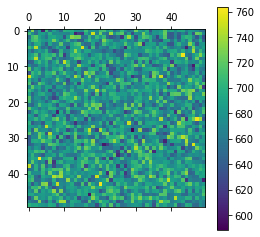

In [27]:
plt.matshow(test_image.cpu().numpy()[0, 0])
plt.colorbar()

In [107]:
np.arange(10)[0:8:2]

array([0, 2, 4, 6])

In [108]:
tmp = test_image[0, 0]

In [109]:
s = 4
out = tmp[0:tmp.shape[0]:s][:, 0:tmp.shape[0]:s]

(array([ 1.,  0.,  0.,  1.,  1.,  2.,  3.,  1.,  3.,  3.,  2.,  3., 12.,
         7.,  6., 13., 16., 16., 17.,  6.,  8.,  6., 14.,  5.,  6.,  7.,
         5.,  1.,  3.,  1.]),
 array([626.4188 , 628.72504, 631.03125, 633.33746, 635.6437 , 637.9499 ,
        640.2561 , 642.5623 , 644.86847, 647.1747 , 649.4809 , 651.7871 ,
        654.0933 , 656.39954, 658.70575, 661.01196, 663.3182 , 665.6244 ,
        667.9306 , 670.2368 , 672.543  , 674.84924, 677.15546, 679.4616 ,
        681.7678 , 684.07404, 686.38025, 688.68646, 690.9927 , 693.2989 ,
        695.6051 ], dtype=float32),
 <BarContainer object of 30 artists>)

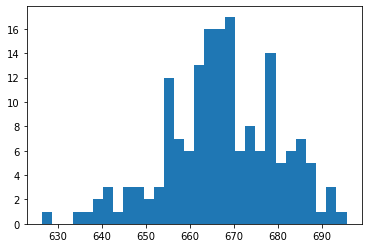

In [110]:
plt.hist(out.flatten().cpu().numpy(), bins = 30)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f87f5163a30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f87f516f190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f87f51636a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f87f516f8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f87f516fc40>],
 'means': []}

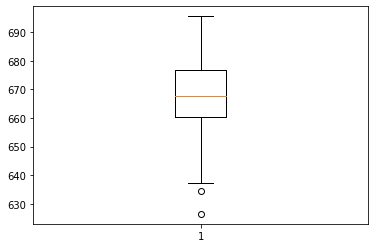

In [111]:
plt.boxplot(out.flatten().cpu().numpy())

In [112]:
np.median(out.cpu())

667.57135

# Get starnet map estimates

In [113]:
map_estimate = sleep_net.image_encoder.map_estimate(test_image.to(device), slen)


# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

### Check the coverage

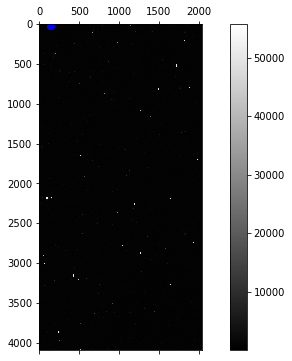

In [114]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

In [115]:
map_estimate['locs']

tensor([[ 41.9508, 153.1295],
        [ 37.8877, 157.0031],
        [ 37.8042, 144.5730],
        [ 41.6973, 146.1443],
        [ 41.7106, 126.0286],
        [ 37.3966, 124.9811],
        [ 37.6636, 135.7428],
        [ 41.7142, 134.3186],
        [ 32.0188, 134.1313],
        [ 27.9051, 135.9299],
        [ 27.4544, 124.9003],
        [ 31.4723, 124.5348],
        [ 31.5111, 144.5165],
        [ 27.8835, 145.9902],
        [ 27.7129, 155.1234],
        [ 31.8312, 155.4546],
        [ 11.6531, 154.1403],
        [  8.1086, 156.1425],
        [  8.0564, 145.3777],
        [ 11.8762, 145.2658],
        [ 11.8361, 126.0391],
        [  7.9671, 124.8835],
        [  8.2886, 135.0887],
        [ 12.1009, 135.6386],
        [ 21.8400, 135.8630],
        [ 17.9196, 134.8882],
        [ 18.1179, 125.3950],
        [ 21.7093, 125.4192],
        [ 21.7259, 144.5049],
        [ 17.5966, 146.1744],
        [ 17.7419, 155.1149],
        [ 21.8493, 155.4719]])

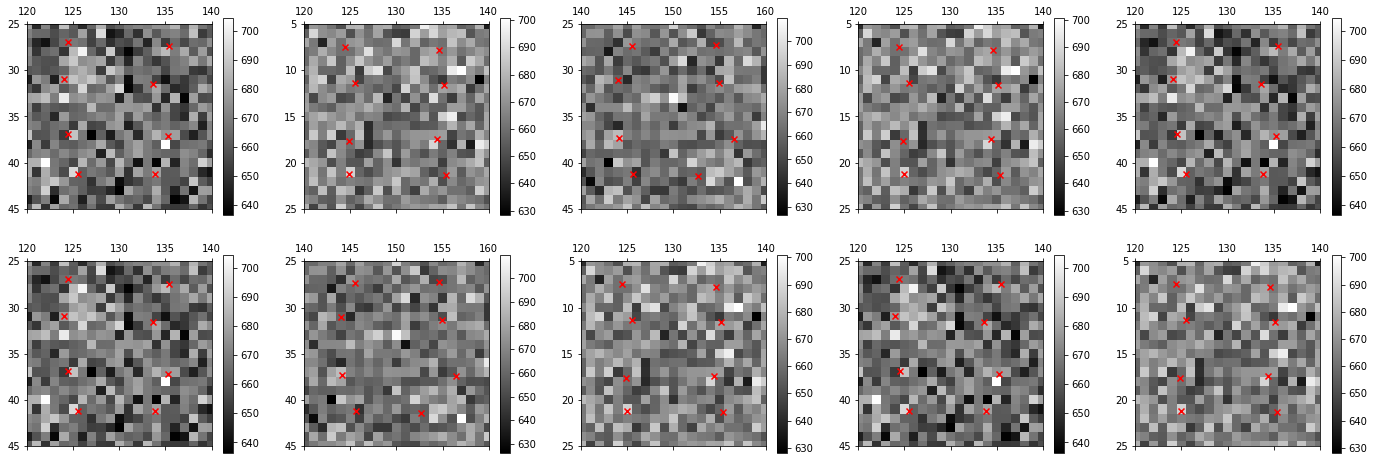

In [116]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 20
x0_vec = np.arange(x0, x0 + slen, subimage_slen)
x1_vec = np.arange(x1, x1 + slen, subimage_slen)

for i in range(10): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

In [117]:
out = dict(foo = 1)

In [119]:
out['something'] = 12

In [120]:
out

{'foo': 1, 'something': 12}

In [121]:
[0] * 5

[0, 0, 0, 0, 0]